# STRATEGY:

- Import files, clean (pre-processing), describe statistics and general info about features
- Feature engineering: derive new features according to metadata
- Calculate correlations between features and with class
    - We should remove features highly correlated with other features, and keep the high correlated with class
- Feature importance with: Logistic Regression, RFECV, PCA, variance
- Distribution of specific features with the class: histograms, density-plots, pivot-tables, scatter-plot
- Class Balancing - MISSING !!!
- Confusion matrix with simple classifiers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#Statistical description of variables
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Brewe, Dr. Arthur Jackson",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
# See the column data types and non-missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Age"] = df["Age"].fillna(np.nan)
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    cut_points = [0,5,12,18,35,60,100]
    label_names = ["Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    #df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------
    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def normalize(df,column_name, mode):
    """Normalize Continuous Columns 

    Usage
    ------
    train = create_dummies(train,"Age")
    """
    if (mode=="n"):
        column=df[column_name]
        new="{}_norm".format(column_name)
        df[new]=(column-column.min())/(column.max()-column.min())
        df[column_name]=df[new]
        df=df.drop([new], axis=1)
    if (mode=="z"):
        column=df[column_name]
        new="{}_norm".format(column_name)
        avg=column.mean()
        var=df.loc[:,column_name].var()
        df[new]=(column-avg)/var
        df[column_name]=df[new]
        df=df.drop([new], axis=1)
        
    
    return df


In [5]:
def pre_process(df):
    df=process_missing(df)
    df=process_age(df)
    df=process_fare(df)
    df=process_cabin(df)
    df=process_titles(df)
    for feature in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex", "Embarked"]:
        df = create_dummies(df,feature)
    numerical=df.select_dtypes(include=['int', 'uint8', 'float'])
    for feature in list(numerical.columns):
        df=normalize(df, feature, "n")
    return df
    
#column=train["Age"]
#train["Age_norm"]=(column-column.min())/(column.max()-column.min())

train=pre_process(train)
holdout=pre_process(holdout)

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 46 columns):
PassengerId                   891 non-null float64
Survived                      891 non-null float64
Pclass                        891 non-null float64
Name                          891 non-null object
Sex                           891 non-null object
Age                           714 non-null float64
SibSp                         891 non-null float64
Parch                         891 non-null float64
Ticket                        891 non-null object
Fare                          891 non-null float64
Cabin                         204 non-null object
Embarked                      891 non-null object
Age_categories                714 non-null category
Fare_categories               891 non-null category
Cabin_type                    891 non-null object
Title                         891 non-null object
Age_categories_Infant         891 non-null float64
Age_categories_Child          891

In [6]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,"Brewe, Dr. Arthur Jackson",male,NaN,NaN,NaN,CA. 2343,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.500000,0.383838,0.654321,NaN,NaN,0.367921,0.065376,0.063599,NaN,0.062858,...,0.035915,0.014590,0.004489,0.001122,0.771044,0.352413,0.647587,0.188552,0.086420,0.725028
std,0.289162,0.486592,0.418036,NaN,NaN,0.182540,0.137843,0.134343,NaN,0.096995,...,0.186182,0.119973,0.066890,0.033501,0.420397,0.477990,0.477990,0.391372,0.281141,0.446751
min,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.500000,NaN,NaN,0.247612,0.000000,0.000000,NaN,0.015440,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,1.000000,NaN,NaN,0.346569,0.000000,0.000000,NaN,0.028213,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.750000,1.000000,1.000000,NaN,NaN,0.472229,0.125000,0.000000,NaN,0.060508,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000


In [7]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Fare_categories', 'Cabin_type', 'Title', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [8]:
train.Age

0      0.271174
1      0.472229
2      0.321438
3      0.434531
4      0.434531
5           NaN
6      0.673285
7      0.019854
8      0.334004
9      0.170646
10     0.044986
11     0.723549
12     0.246042
13     0.484795
14     0.170646
15     0.685851
16     0.019854
17          NaN
18     0.384267
19          NaN
20     0.434531
21     0.421965
22     0.183212
23     0.346569
24     0.095250
25     0.472229
26          NaN
27     0.233476
28          NaN
29          NaN
         ...   
861    0.258608
862    0.597889
863         NaN
864    0.296306
865    0.522493
866    0.334004
867    0.384267
868         NaN
869    0.044986
870    0.321438
871    0.585323
872    0.409399
873    0.585323
874    0.346569
875    0.183212
876    0.246042
877    0.233476
878         NaN
879    0.698417
880    0.308872
881    0.409399
882    0.271174
883    0.346569
884    0.308872
885    0.484795
886    0.334004
887    0.233476
888         NaN
889    0.321438
890    0.396833
Name: Age, Length: 891, 

In [9]:
#Derived feature 1

train["SibSp+Parch"]=train.SibSp+train.Parch
holdout["SibSp+Parch"]=holdout.SibSp+holdout.Parch

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,...,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,SibSp+Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.500000,0.383838,0.654321,0.367921,0.065376,0.063599,0.062858,0.049383,0.028058,0.078563,...,0.014590,0.004489,0.001122,0.771044,0.352413,0.647587,0.188552,0.086420,0.725028,0.128975
std,0.289162,0.486592,0.418036,0.182540,0.137843,0.134343,0.096995,0.216787,0.165232,0.269207,...,0.119973,0.066890,0.033501,0.420397,0.477990,0.477990,0.391372,0.281141,0.446751,0.228938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.500000,0.247612,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,1.000000,0.346569,0.000000,0.000000,0.028213,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.750000,1.000000,1.000000,0.472229,0.125000,0.000000,0.060508,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.166667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.333333


In [10]:
#Derived feature number 2

train['isalone'] = np.where(train['SibSp+Parch']==0, "1", "0")
holdout['isalone'] = np.where(holdout['SibSp+Parch']==0, "1", "0")

train['isalone'] = pd.to_numeric(train['isalone'], errors='coerce')
holdout['isalone'] = pd.to_numeric(holdout['isalone'], errors='coerce')

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 48 columns):
PassengerId                   891 non-null float64
Survived                      891 non-null float64
Pclass                        891 non-null float64
Name                          891 non-null object
Sex                           891 non-null object
Age                           714 non-null float64
SibSp                         891 non-null float64
Parch                         891 non-null float64
Ticket                        891 non-null object
Fare                          891 non-null float64
Cabin                         204 non-null object
Embarked                      891 non-null object
Age_categories                714 non-null category
Fare_categories               891 non-null category
Cabin_type                    891 non-null object
Title                         891 non-null object
Age_categories_Infant         891 non-null float64
Age_categories_Child          891

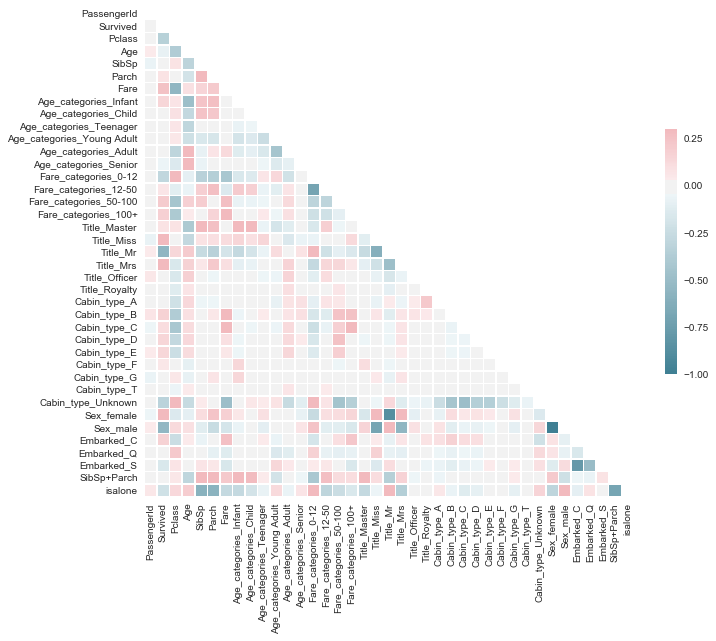

In [11]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(train)

In [12]:
correlations_data = train.corr()['Survived'].sort_values()
print(correlations_data)

Title_Mr                     -0.549199
Sex_male                     -0.543351
Pclass                       -0.338481
Cabin_type_Unknown           -0.316912
Fare_categories_0-12         -0.287849
isalone                      -0.203367
Embarked_S                   -0.149683
Age                          -0.077221
Age_categories_Senior        -0.051224
SibSp                        -0.035322
Title_Officer                -0.031316
Cabin_type_T                 -0.026456
Age_categories_Child         -0.008328
PassengerId                  -0.005007
Age_categories_Young Adult   -0.001949
Embarked_Q                    0.003650
Cabin_type_G                  0.016040
Age_categories_Adult          0.017590
Cabin_type_A                  0.022287
SibSp+Parch                   0.026633
Age_categories_Teenager       0.026859
Title_Royalty                 0.033391
Cabin_type_F                  0.057935
Fare_categories_12-50         0.065790
Parch                         0.081629
Title_Master             

Train: 48
Train_num: 38
Valid_train: 37


/home/andreia/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


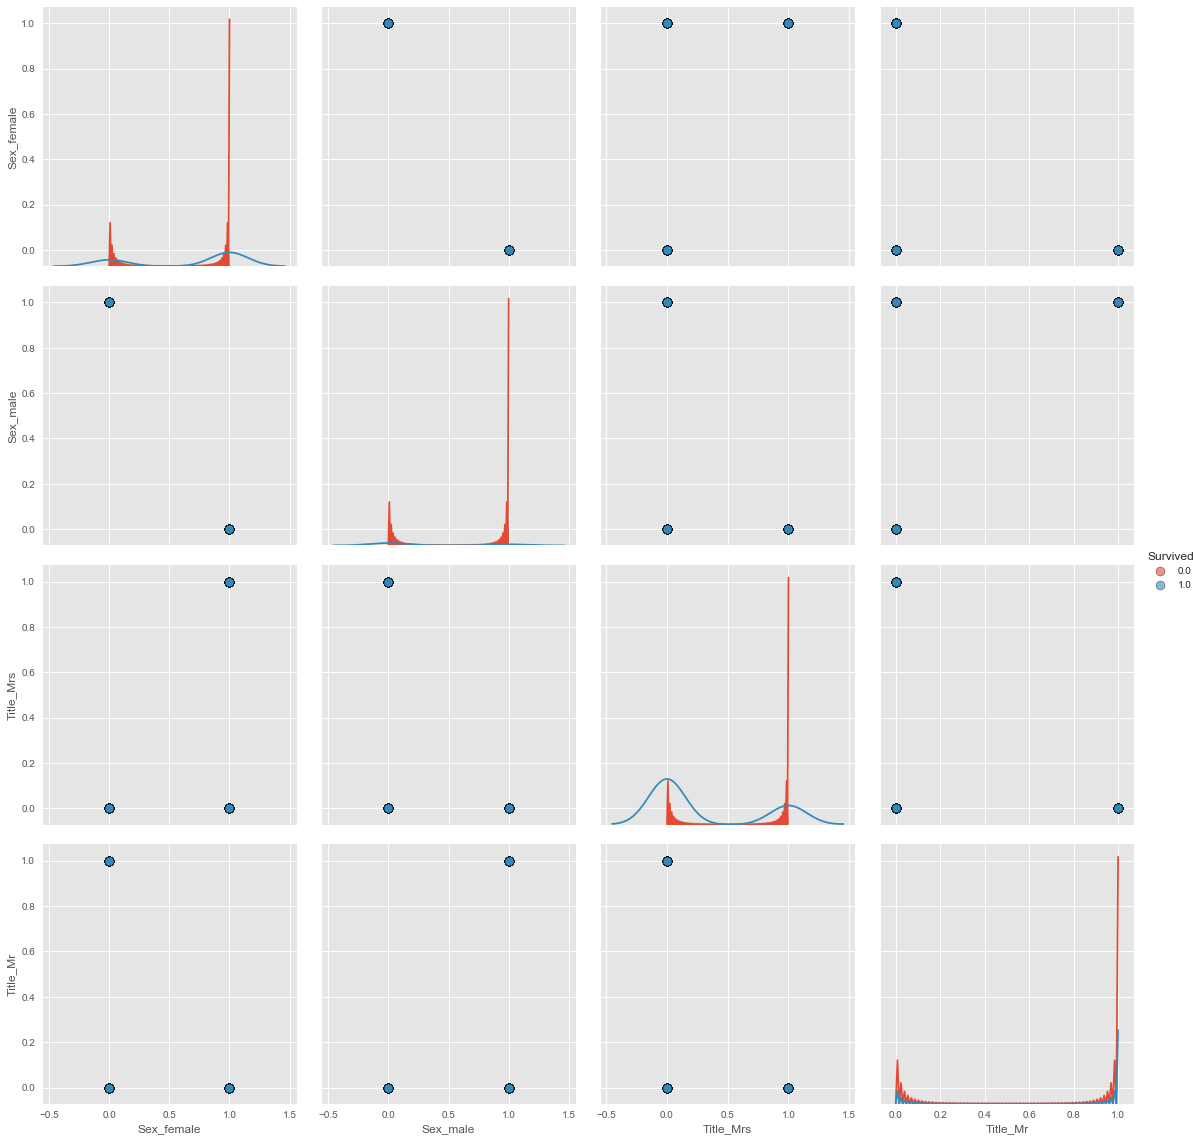

In [48]:
print("Train:", len(train.columns))
train_numS=train.select_dtypes(include=['int', 'uint8', 'float'])
holdout_numS=holdout.select_dtypes(include=['int', 'uint8', 'float'])

train_num=train.select_dtypes(include=['int', 'uint8', 'float']).drop(['Survived'], axis=1)
holdout_num=train.select_dtypes(include=['int', 'uint8', 'float']).drop(['Survived'], axis=1)

print("Train_num:", len(train_num.columns))

valid_train=train_num.dropna(axis='columns')
valid_holdout=holdout_num.dropna(axis='columns')

print("Valid_train:", len(valid_train.columns))
#train_feat=train.drop(['PassengerId','Survived', 'Sex', 'Fare', 'Embarked', 'Age_norm', 'Age', 'Name', 'Ticket', 'Title', 'Cabin','Cabin_type', 'Age_categories','Fare_categories'], axis=1)

sns.pairplot(train_numS, vars = ['Sex_female', 'Sex_male', 'Title_Mrs', 'Title_Mr'], 
             hue = 'Survived', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)

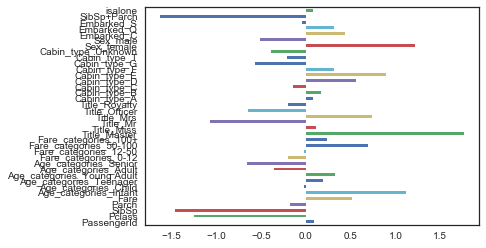

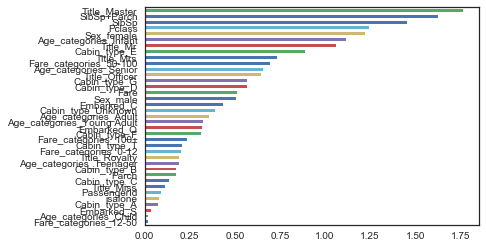

In [14]:
#Feature importance with: Logistic Regression, RFECV, PCA

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(valid_train,train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index=valid_train.columns)
feature_importance.plot.barh()
plt.show()
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()


/home/andreia/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


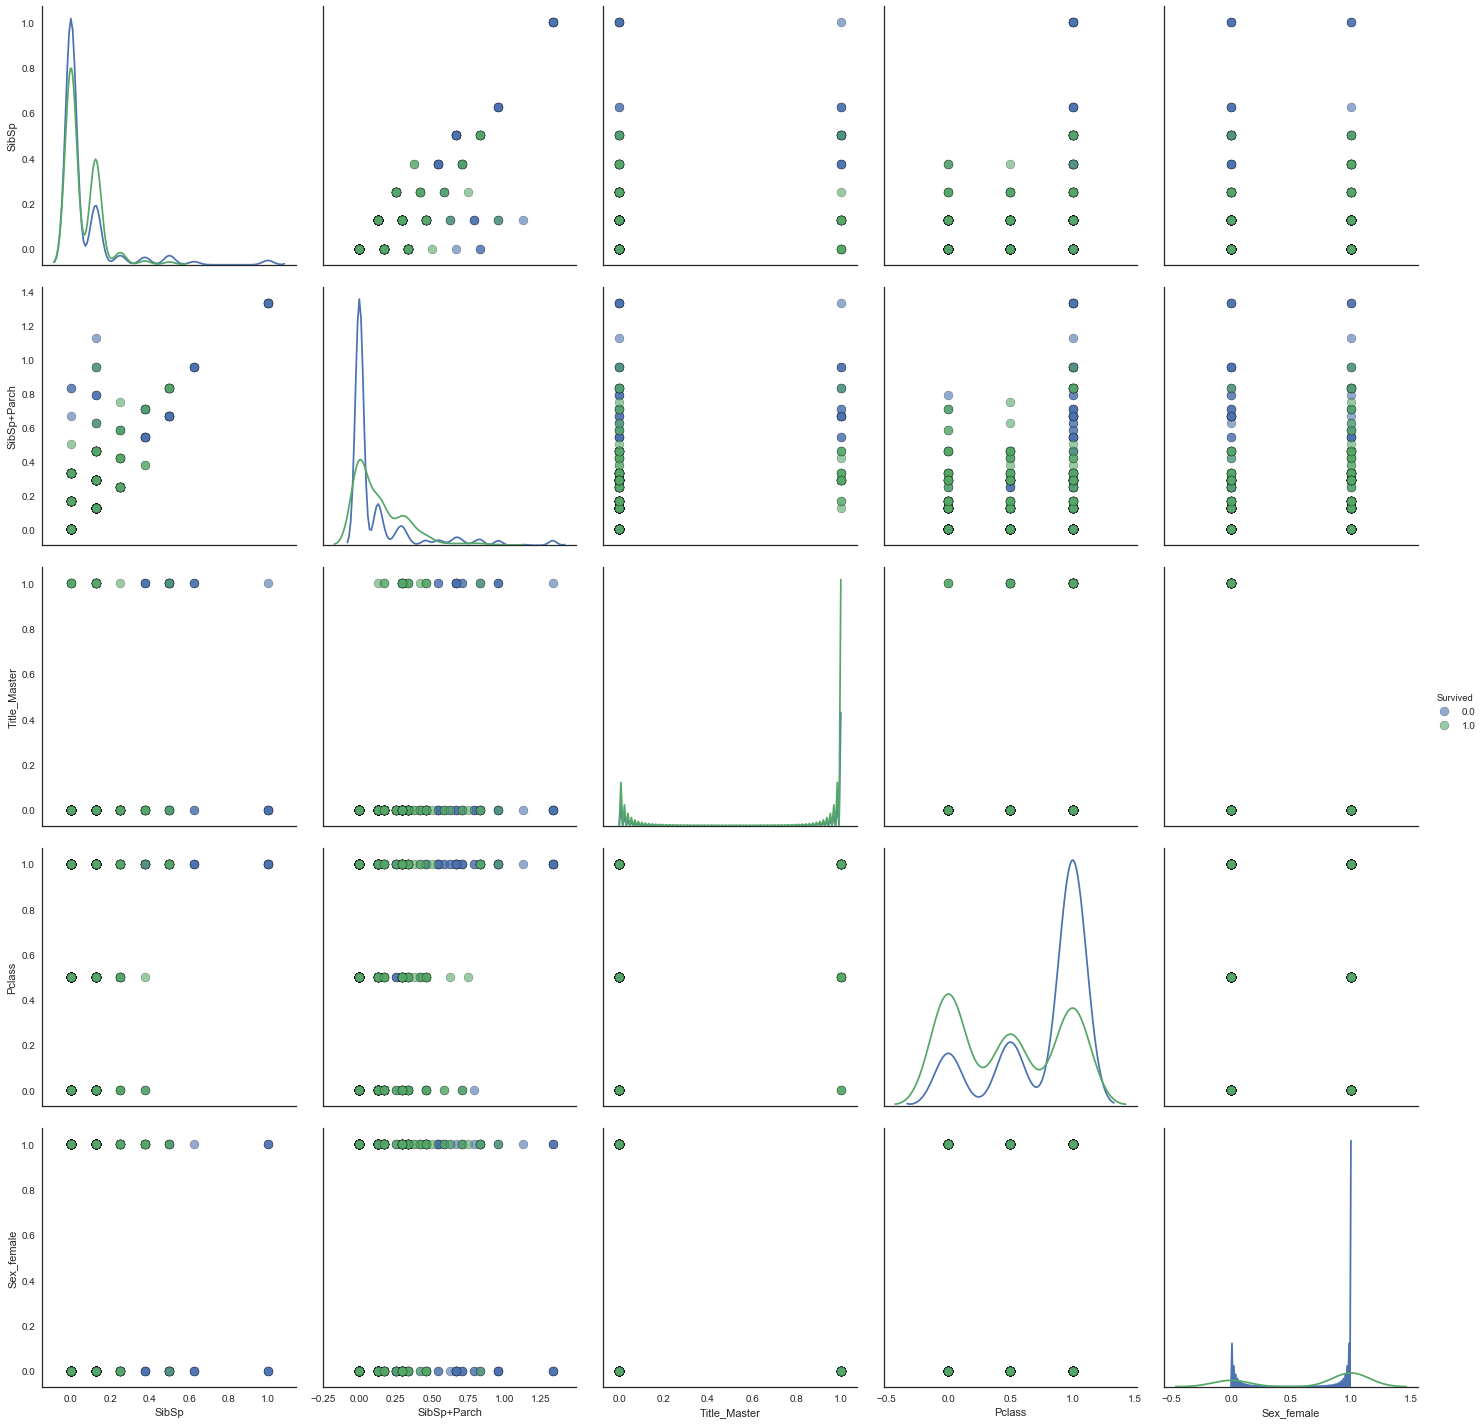

In [15]:
sns.pairplot(train_numS, vars = ['SibSp', 'SibSp+Parch', 'Title_Master', 'Pclass', 'Sex_female'], 
             hue = 'Survived', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)

In [16]:
from sklearn.feature_selection import RFECV
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(valid_train,train['Survived'])

print("ALL COLUMNS:")
print(valid_train.columns)
print()
print("CHOSEN COLUMNS:")
print(selector.support_)

optimized_columns = valid_train.columns[selector.support_]

print(optimized_columns)


ALL COLUMNS:
Index(['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp+Parch', 'isalone'],
      dtype='object')

CHOSEN COLUMNS:
[False  True  True False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False  True False False False False  True
 False]
Index

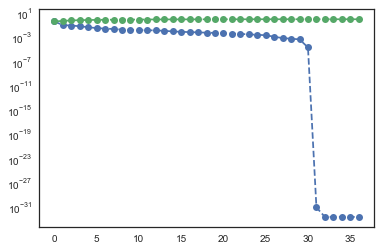

In [17]:
#Feature importance with PCA
#Each PC is a linear combination of single variables. The eigenvector is the line that describes that combination
#Eigenvalues are the sum of squared distances from each projcted point to the origin of the plot.
#Each point has a new coordinate given by its eigenvalue.
#The several PCAs are produced by making orthogonal lines to the best line, as many as there are coordinates

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

valid_trainZ=valid_train.copy()

for feature in list(valid_trainZ.columns):
    if (feature!="Survived"):
        valid_trainZ=normalize(valid_trainZ, feature, "z")

pca_trafo = PCA().fit(valid_trainZ);

plt.semilogy(pca_trafo.explained_variance_ratio_, '--o');
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o');


/home/andreia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


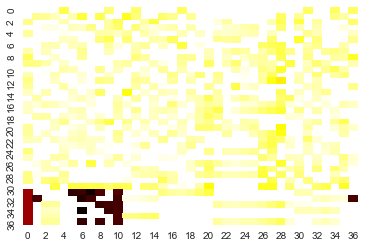

In [18]:
pca_data=pca_trafo.transform(valid_trainZ)

sns.heatmap(np.log(pca_trafo.inverse_transform(np.eye(pca_data.shape[1]))), cmap="hot", cbar=False)

#Y axis: principal component
#X axis: orifginal feature Index

/home/andreia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


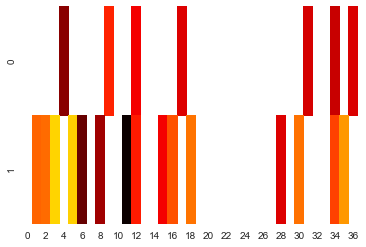

In [19]:
pca_trafo=PCA(n_components=2, svd_solver='full').fit(valid_trainZ)
pca_data=pca_trafo.transform(valid_trainZ)

sns.heatmap(np.log(pca_trafo.inverse_transform(np.eye(pca_data.shape[1]))), cmap="hot", cbar=False)

#Y axis: principal component
#X axis: orifginal feature Index

In [20]:
import math
def get_important_features(transformed_features, components_, columns):
    num_columns = len(columns)
    # Scale the principal components by the max value in the transformed set
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    # Sort each original column by it's length
    impt_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    impt_features = sorted(zip(impt_features.values(),impt_features.keys()),reverse=True)
    print("Features by importance:")
    for feat in impt_features:
          print(feat)


get_important_features(pca_data, pca_trafo.components_, valid_trainZ.columns.values)

Features by importance:
(889.9921324574933, 'Cabin_type_T')
(222.04748441834496, 'Cabin_type_G')
(13.347379031808499, 'Parch')
(11.69623074655272, 'Age_categories_Infant')
(8.540816064548226, 'Title_Royalty')
(6.158593816414921, 'SibSp+Parch')
(5.794330491954031, 'Cabin_type_Unknown')
(5.57684100146534, 'Fare')
(4.954189658632875, 'SibSp')
(4.8728416266773, 'Age_categories_Adult')
(4.6568657112658665, 'Pclass')
(3.83876263194575, 'isalone')
(3.702270919438955, 'PassengerId')
(3.6604435008965868, 'Sex_male')
(3.66044350089658, 'Sex_female')
(3.5988078037703444, 'Title_Mrs')
(3.452555734310008, 'Title_Mr')
(3.188772207768089, 'Cabin_type_A')
(2.6580979915478284, 'Fare_categories_12-50')
(2.5455856816379794, 'Title_Miss')
(2.2032166718638164, 'Embarked_S')
(2.0614988159707135, 'Embarked_C')
(2.0597215161546765, 'Title_Officer')
(2.0123690848730815, 'Cabin_type_B')
(1.9669382592134288, 'Fare_categories_100+')
(1.9659671935105187, 'Age_categories_Senior')
(1.8744430789862756, 'Fare_categori

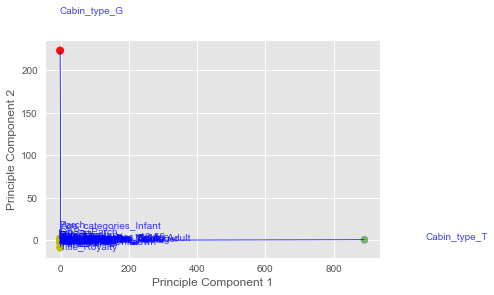

In [21]:
plt.style.use('ggplot')
def draw_vectors(transformed_features, components_, columns):
    num_columns = len(columns)
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    ax = plt.axes()
    for i in range(num_columns):
        # Use an arrow to project each original feature as a labeled vector
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2,yvector[i]*1.2,list(columns)[i],color='b',alpha=0.75)
    return ax

df=valid_trainZ
ax = draw_vectors(pca_data, pca_trafo.components_, df.columns.values)
T_df = pd.DataFrame(pca_data)
T_df.columns = ['component1', 'component2']
T_df['color'] = 'y'
T_df.loc[T_df['component1'] > 125, 'color'] = 'g'
T_df.loc[T_df['component2'] > 125, 'color'] = 'r'
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.scatter(T_df['component1'], T_df['component2'], color=T_df['color'], alpha=0.5)
plt.show()

In [23]:
#feature importance by high variance
from sklearn.feature_selection import VarianceThreshold

print(valid_train.shape)

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
valid_train_var = sel.fit_transform(valid_train)

print(valid_train_var.shape)

mask = sel.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(valid_train.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)

(891, 37)
(891, 12)
['Pclass', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Embarked_S', 'isalone']


In [24]:
#Classification scores: chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X=valid_train
y=train ['Survived']
print(X.shape)
sel=SelectKBest(chi2, k=5)
X_new = sel.fit_transform(X, y)
print(X_new.shape)

mask = sel.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(X.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)

(891, 37)
(891, 5)
['Title_Miss', 'Title_Mr', 'Title_Mrs', 'Sex_female', 'Sex_male']


In [25]:
#Classification scores: chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X=valid_train
y=train ['Survived']
print(X.shape)
sel=SelectKBest(f_classif, k=5)
X_new = sel.fit_transform(X, y)
print(X_new.shape)

mask = sel.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(X.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)

(891, 37)
(891, 5)
['Pclass', 'Title_Mr', 'Title_Mrs', 'Sex_female', 'Sex_male']


In [26]:
#Classification scores: chi2, f_classif, mutual_info_classif

#f_classif: Compute the ANOVA F-value for the provided sample.
#mutual_info_classif: tests if the features are independent from a discrete target variable (Mutual Information metric)
#chi-square test measures dependence between stochastic variables

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

X=valid_train
y=train ['Survived']
print(X.shape)
sel=SelectKBest(mutual_info_classif, k=5)
X_new = sel.fit_transform(X, y)
print(X_new.shape)

mask = sel.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(X.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)

(891, 37)
(891, 5)
['Pclass', 'Fare', 'Title_Mr', 'Sex_female', 'Sex_male']


In [27]:
#Classification scores: f_regression
#Linear model for testing the individual effect of each of many regressors.
#1)The correlation between each regressor and the target is computed
#2)It is converted to an F score then to a p-value.

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

X=valid_train
y=train ['Survived']
print(X.shape)
sel=SelectPercentile(f_regression, percentile=30)
X_new = sel.fit_transform(X, y)
print(X_new.shape)

mask = sel.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(X.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)

(891, 37)
(891, 11)
['Pclass', 'Fare', 'Fare_categories_0-12', 'Fare_categories_50-100', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/home/andreia/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/home/andreia/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


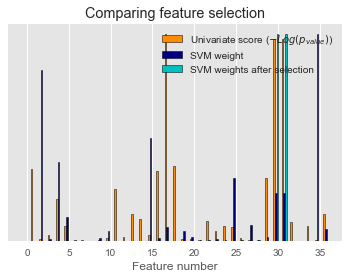

In [28]:
#SVM
from sklearn import svm
# Add some noisy data to iris informative features

#E = np.random.uniform(0, 0.1, size=(valid_train.shape[0], valid_train.shape[1]))
#X = np.hstack((valid_train, E))
X=valid_train
y = train['Survived']
X_indices = np.arange(X.shape[-1])


# Univariate feature selection with F-test for feature scoring
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
# Compare to the weights of an SVM
clf = svm.SVC(kernel='linear')
clf.fit(X, y)
svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)
svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()
# PLOT
plt.figure(1)
plt.clf()
plt.bar(X_indices - .45, scores, width=.2, label=r'Univariate score ($-Log(p_{value})$)', color='darkorange', edgecolor='black')
plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight', color='navy', edgecolor='black')
plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected, width=.2, label='SVM weights after selection', color='c', edgecolor='black')
plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

Duvidas:
    - PCA values nao tem nada em comum com regression
    - PCA plot esta terrivel
    - mutual_info_classif deu male em vez de female

(chi2 dados numericos)

    - SVM Noise ? 
    - 1.5 Comparing ranking criteria -??
    - Subset é respectivo a base de dados ou a 1 classe de varias?

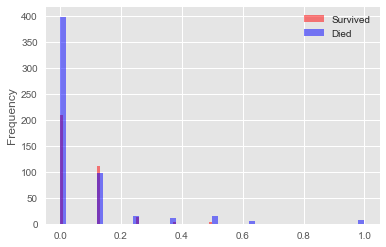

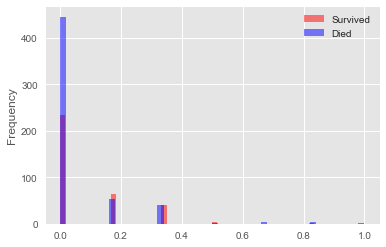

In [29]:
#Distribution of each feature with 2 classes in: 
#histograms - discrete variables
#density plots - continuous variables
#pivot tables - all variables
#scatter plots - all variables.


survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

survived["SibSp"].plot.hist(alpha=0.5,color='red',bins=50)
died["SibSp"].plot.hist(alpha=0.5,color='blue',bins=50)

plt.legend(['Survived','Died'])
plt.show()

survived["Parch"].plot.hist(alpha=0.5,color='red',bins=50)
died["Parch"].plot.hist(alpha=0.5,color='blue',bins=50)

plt.legend(['Survived','Died'])
plt.show()

/home/andreia/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/andreia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


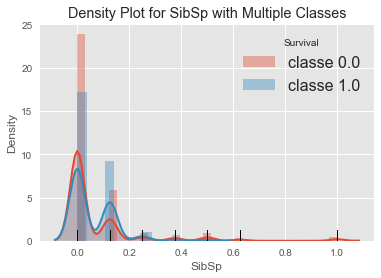

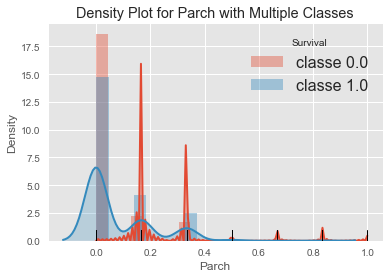

In [30]:

classes=list(train['Survived'].unique())

# List of 2 features to plot
features = ['SibSp', 'Parch']

for feature in features:
    plt.figure()

    for i in classes: 
        # Subset to the class
        subset = train[train['Survived']==i]
    
        # Draw the density plot
        lab="classe {}".format(i)
        sns.distplot(subset[feature], hist = True, kde = True, rug = True, kde_kws = {'shade':True, 'linewidth': 2}, rug_kws={'color': 'black'}, label = lab)

        # Plot formatting
        plt.legend(prop={'size': 16}, title = 'Survival')
        plt.title('Density Plot for '+feature+' with Multiple Classes')
        plt.xlabel(feature)
        plt.ylabel('Density')



In [31]:
#!!! Deixa de fazer sentido quando normalizamos variaveis ordinais


sex_pivot = train.pivot_table(index="SibSp",values="Survived")
print(sex_pivot)

sex_pivot = train.pivot_table(index="Parch",values="Survived")
print(sex_pivot)

       Survived
SibSp          
0.000  0.345395
0.125  0.535885
0.250  0.464286
0.375  0.250000
0.500  0.166667
0.625  0.000000
1.000  0.000000
          Survived
Parch             
0.000000  0.343658
0.166667  0.550847
0.333333  0.500000
0.500000  0.600000
0.666667  0.000000
0.833333  0.200000
1.000000  0.000000


                                           Plots for SibSp                                            


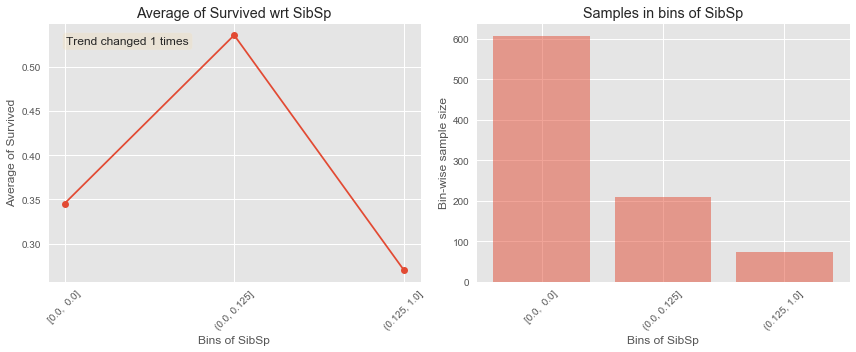

--------------------------------------------------------------------------------------------------------------


                                           Plots for Parch                                            


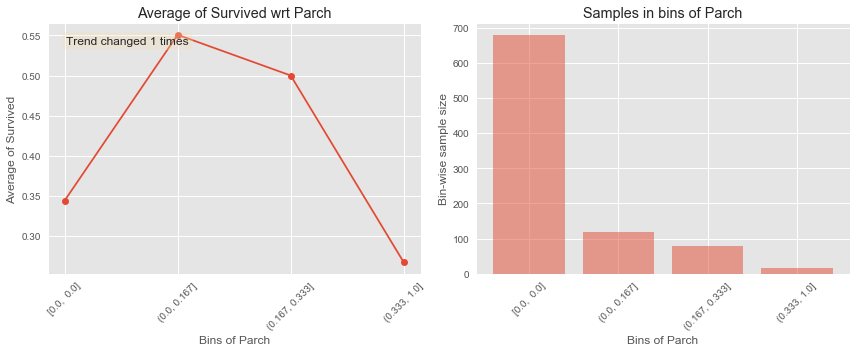

--------------------------------------------------------------------------------------------------------------


                                        Plots for SibSp+Parch                                         


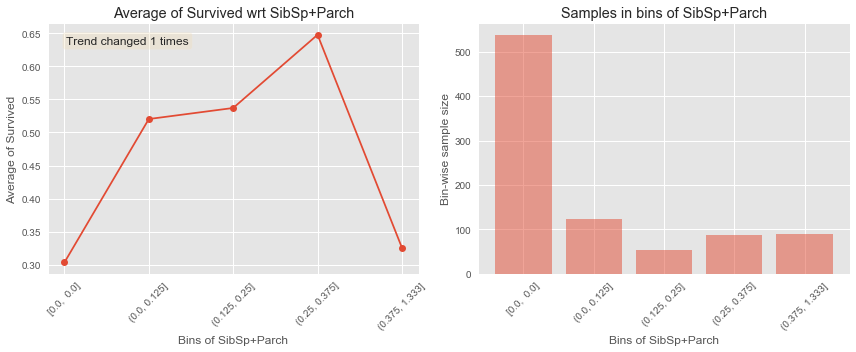

--------------------------------------------------------------------------------------------------------------




In [32]:
from featexp import get_univariate_plots

# Plots drawn for all features if nothing is passed in feature_list parameter.
get_univariate_plots(data=train, target_col="Survived", features_list=["SibSp", "Parch", "SibSp+Parch"], bins=3)

/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[[139  26]
 [ 45  58]]


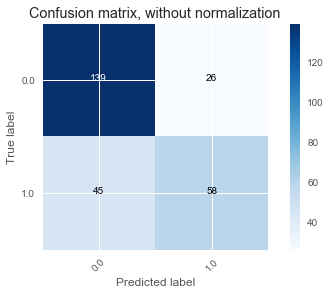

In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 30 19:52:17 2018

@author: claudia
"""

import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


def plot_confusion_matrix(cnf_matrix, classesNames, normalize=False,
                          cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)

    if normalize:
        soma = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / soma
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix, without normalization'

    print(cm)

    plt.figure()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classesNames))
    plt.xticks(tick_marks, classesNames, rotation=45)
    plt.yticks(tick_marks, classesNames)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


data = valid_trainZ
X = data
y = train['Survived']
labels = pd.unique(y)

trX, tsX, trY, tsY = train_test_split(X, y, train_size=0.7, stratify=y)

knn = KNeighborsClassifier(n_neighbors=3)
model = knn.fit(trX, trY)
predY = model.predict(tsX)

cnf_matrix = confusion_matrix(tsY, predY, labels)
plot_confusion_matrix(cnf_matrix, labels)



[[0.84 0.16]
 [0.44 0.56]]


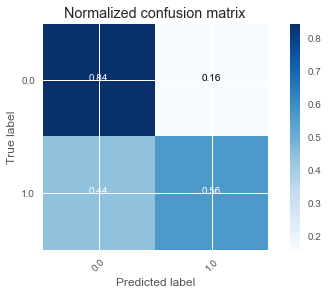

In [34]:
plot_confusion_matrix(cnf_matrix, labels, True)


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 

knn={
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
}

rf={
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
}

lr={
    "name": "LogisticrRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"]
    }
}

models=[knn, rf, lr]
X = valid_train
y = train['Survived']

for dic in models:
    model = dic['estimator']
    hyperparamenters = dic['hyperparameters']
    grid = GridSearchCV(model, param_grid=hyperparamenters, cv=10)

    grid.fit(X, y)
    print(grid.best_params_)
    print(grid.best_score_)



{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.8215488215488216
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 9}
0.8406285072951739
{'solver': 'newton-cg'}
0.8249158249158249


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 

knn={
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
}

rf={
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
}

lr={
    "name": "LogisticrRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"]
    }
}

models=[knn, rf, lr]
X = valid_train[['Pclass', 'SibSp', 'Title_Master', 'Sex_female', 'SibSp+Parch']]
y = train['Survived']

for dic in models:
    model = dic['estimator']
    hyperparamenters = dic['hyperparameters']
    grid = GridSearchCV(model, param_grid=hyperparamenters, cv=10)

    grid.fit(X, y)
    print(grid.best_params_)
    print(grid.best_score_)



{'algorithm': 'brute', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
0.8181818181818182
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6}
0.8316498316498316
{'solver': 'newton-cg'}
0.8282828282828283


In [51]:
X = valid_train
Y = train['Survived']
x = valid_holdout

cls=RandomForestClassifier(criterion='gini', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 9)

cls.fit(X, Y)
predictions=cls.predict(x)
